<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/faceMaskDetection/faceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Change working directory
%cd /content/drive/My Drive/Colab Notebooks/face_mask_detection

/content/drive/My Drive/Colab Notebooks/face_mask_detection


In [ ]:
# Import libraries
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

print(f'Tensorflow version: {tf.__version__}')

# Config
%config InlineBackend.figure_format = 'retina' #Retina display

GPU is available
Tensorflow version: 2.7.0


In [ ]:
# Images processing
img_generator = ImageDataGenerator(
    rescale = 1 / 255.0,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Training set creation
train = img_generator.flow_from_directory(
    os.getcwd(), 
    target_size = (224, 224),
    classes = ['with_mask', 'without_mask'], #2-classes
    class_mode = 'categorical', 
    batch_size = 64, 
    shuffle = True
)

Found 1376 images belonging to 2 classes.


In [ ]:
# Model design
based_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
) #MobileNetV2
based_model.trainable = False #Not to change weights

# Model architecture
model = Sequential()
model.add(based_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                           

In [ ]:
# Define optimizer and compile
opt = Adam(
    learning_rate  = 0.001,
    decay = 0.001 / 20
)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)

In [ ]:
#Model traning
model.fit(
    train,
    batch_size = 64,
    epochs = 10
)

Epoch 1/10
22/22 [==============================] - 199s 8s/step - loss: 0.2153 - accuracy: 0.9288
Epoch 2/10
22/22 [==============================] - 28s 1s/step - loss: 0.0577 - accuracy: 0.9876
Epoch 3/10
22/22 [==============================] - 29s 1s/step - loss: 0.0248 - accuracy: 0.9927
Epoch 4/10
22/22 [==============================] - 34s 2s/step - loss: 0.0140 - accuracy: 0.9949
Epoch 5/10
22/22 [==============================] - 43s 2s/step - loss: 0.0089 - accuracy: 0.9978
Epoch 6/10
22/22 [==============================] - 29s 1s/step - loss: 0.0087 - accuracy: 0.9985
Epoch 7/10
22/22 [==============================] - 25s 1s/step - loss: 0.0083 - accuracy: 0.9971
Epoch 8/10
22/22 [==============================] - 25s 1s/step - loss: 0.0123 - accuracy: 0.9964
Epoch 9/10
22/22 [==============================] - 26s 1s/step - loss: 0.0096 - accuracy: 0.9964
Epoch 10/10
22/22 [==============================] - 35s 2s/step - loss: 0.0169 - accuracy: 0.9927


In [ ]:
# Save model
model.save('face_mask.model')

INFO:tensorflow:Assets written to: face_mask.model/assets


INFO:tensorflow:Assets written to: face_mask.model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Try to load trained model
loadedModel = load_model('face_mask.model')

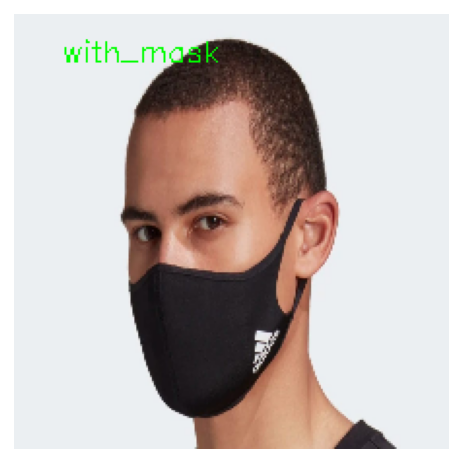

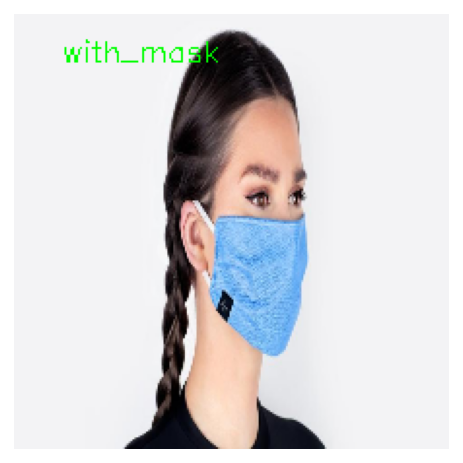

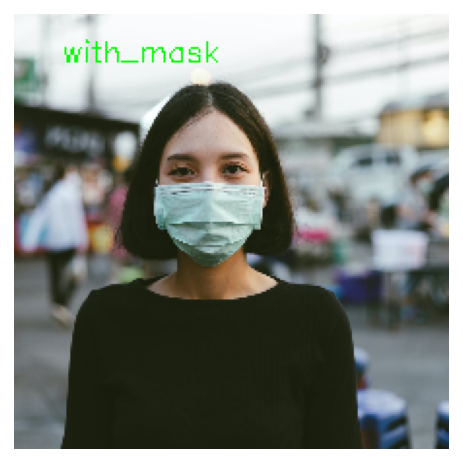

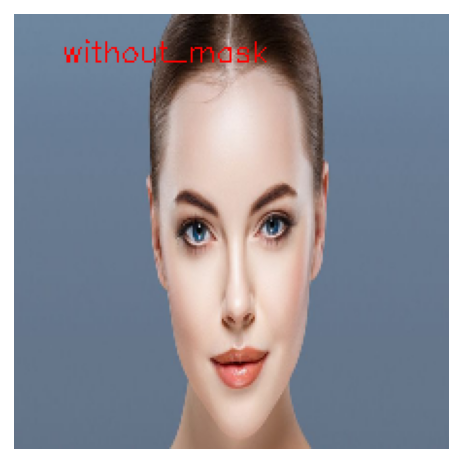

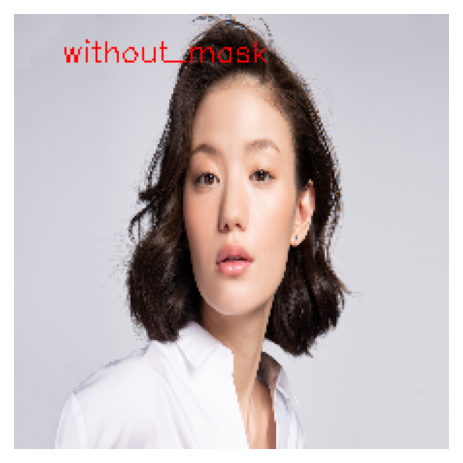

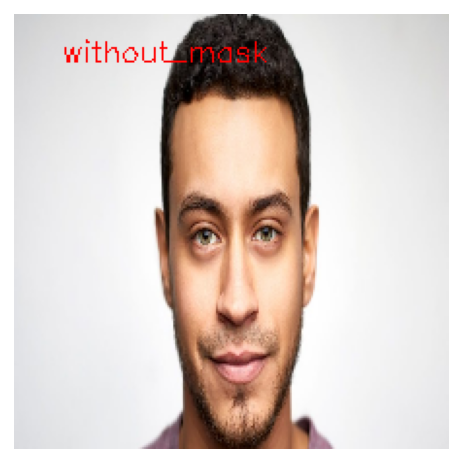

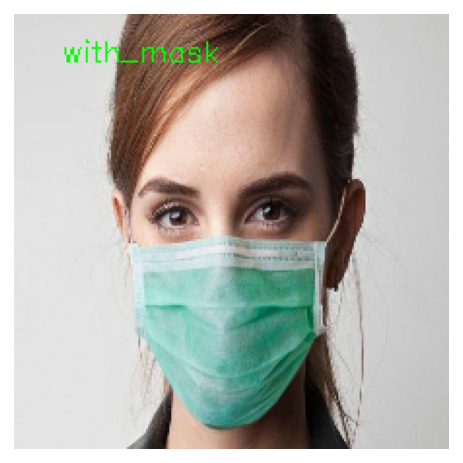

In [ ]:
# Model prediction with image
results = ['with_mask', 'without_mask'] #'with_mask' --> 0, 'without_mask' --> 1 
sizes = (224, 224) #Same as training model

for imageFile in os.listdir(os.getcwd()):
  if imageFile.endswith('jpg'):
    image = cv2.imread(imageFile)
    image = cv2.resize(image, sizes)
    imgArray = image.reshape(-1, sizes[0], sizes[1], 3) / 255.0
    pred = loadedModel.predict(imgArray, batch_size = 64) #Same as training model
    label = results[np.argmax(pred)] #Get label
    if label == results[0]:
      fontColor = (0, 255, 0)
    else:
      fontColor = (0, 0, 255)
    cv2.putText(
        image,
         label,
         (sizes[0] - 200, sizes[1] - 200),
         cv2.FONT_HERSHEY_SIMPLEX,
         0.5,
         fontColor,
         1
    )
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()